In [1]:
import numpy as np
# import vunet
# import vunet_simple as vunet
import vunet_1 as vunet
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam

import h5py

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('jet')

<Figure size 432x288 with 0 Axes>

In [3]:
import tensorflow as tf
from keras import backend as K

# tf.session specification
# TensorFlow wizardry
config = tf.ConfigProto()

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.85

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

#### Load/select data

In [15]:
model_string = 'vunet_norm'
output_dir = 'saved_models/'
# case_string = 'horizontal_16w'
case_string = 'horizontal_16w_fix_perm_test'
data_dir = '/data/cees/zjin/cs231n/project/var-unet/data/'

hf_r = h5py.File(data_dir + case_string + '.hdf5', 'r')
# hf_r = h5py.File(data_dir + case_string + '_aug.hdf5', 'r')
data_train = np.array(hf_r.get('data_train'))
data_eval = np.array(hf_r.get('data_eval'))
hf_r.close()

print(data_train.shape)
print(data_eval.shape)

n_trial_data = 0
data_train_trial = data_train[:n_trial_data,...]
print(data_train_trial.shape)

n_eval_data = 8000
data_eval_trial = data_eval[:n_eval_data,...]
print(data_eval_trial.shape)

(0, 128, 128, 3, 2)
(8000, 128, 128, 3, 2)
(0, 128, 128, 3, 2)
(8000, 128, 128, 3, 2)


In [16]:
# data_train_trial shape (?, 128, 128, 3, 2)
train_x_y_hat0 = data_train_trial[..., 0]# xc
train_y_hat0 = data_train_trial[..., [0], 1] #c
train_x_hat0 = data_train_trial[..., 1:, 1] # x

print(train_x_y_hat0.shape)
print(train_y_hat0.shape)
print(train_x_hat0.shape)

eval_x_y_hat0 = data_eval_trial[..., 0]# xc
eval_y_hat0 = data_eval_trial[..., [0], 1] #c
eval_x_hat0 = data_eval_trial[..., 1:, 1] # x

print(eval_x_y_hat0.shape)
print(eval_y_hat0.shape)
print(eval_x_hat0.shape)

# eval_x_y_hat0, eval_y_hat0, eval_x_hat0

(0, 128, 128, 3)
(0, 128, 128, 1)
(0, 128, 128, 2)
(8000, 128, 128, 3)
(8000, 128, 128, 1)
(8000, 128, 128, 2)


In [60]:
case_string = 'horizontal_16w_fix_perm'
epoch = 10
learning_rate = 2e-4 # default 1e-3

# train_nr = data_train_trial.shape[0]
# eval_nr = data_eval_trial.shape[0]
train_nr = 7600
eval_nr = 784


input_shape = (128,128,3)
w_shape = (128,128,1)
output_shape = (128,128,2)

n_res_block = 1
n_low_res = 0 # 6
n_scales = 5


# enc_up, hidden_shapes = vunet.create_enc_up(input_shape, n_scales = 8)
# enc_down = vunet.create_enc_down(latent_shape)
# dec_up = vunet.create_dec_up(output_shape, n_scales = 8) # only c input
# dec_down = vunet.create_dec_down(hidden_shapes, latent_shape, n_scales = 8)

enc_up, hidden_shapes = vunet.create_enc_up(input_shape, n_scales = n_scales)
enc_down = vunet.create_enc_down(hidden_shapes[-1])
dec_up = vunet.create_dec_up(w_shape, n_scales = n_scales) # only c input
dec_down = vunet.create_dec_down(hidden_shapes, hidden_shapes[-1], output_shape, n_scales = n_scales, n_low_res = n_low_res)

enc_up.load_weights(output_dir + 'enc_up_norm_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
enc_down.load_weights(output_dir + 'enc_down_norm_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
dec_up.load_weights(output_dir + 'dec_up_norm_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
dec_down.load_weights(output_dir + 'dec_down_norm_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))

In [61]:
xc = Input(shape=input_shape) # perm + well location
c = Input(shape=w_shape) # well location

hs = enc_up(xc)
z_posterior_sample, z_posterior_mean = enc_down(hs[-1])
gs = dec_up(c)
x_hat, z_piror_sample, z_piror_mean = dec_down([z_posterior_mean, *gs])

v_unet_model = Model([xc, c], [x_hat])

In [62]:
x_hat_pred_eval = v_unet_model.predict([eval_x_y_hat0, eval_y_hat0])
print(x_hat_pred_eval.shape)

(8000, 128, 128, 2)


In [ ]:
x_hat_pred_train = v_unet_model.predict([train_x_y_hat0, train_y_hat0])
print(x_hat_pred_train.shape)

## Train simulation results

In [11]:
print(x_hat_pred_train.shape)
print(train_x_hat0.shape)

err = np.abs(x_hat_pred_train - train_x_hat0)
rel_err = np.sum(err, axis=(1,2,3)) / np.sum(train_x_hat0, axis=(1,2,3))
print(rel_err.shape)
print(np.mean(rel_err))

(7600, 128, 128, 2)
(7600, 128, 128, 2)
(7600,)
0.0875101924266629


In [37]:
print(epoch)

10


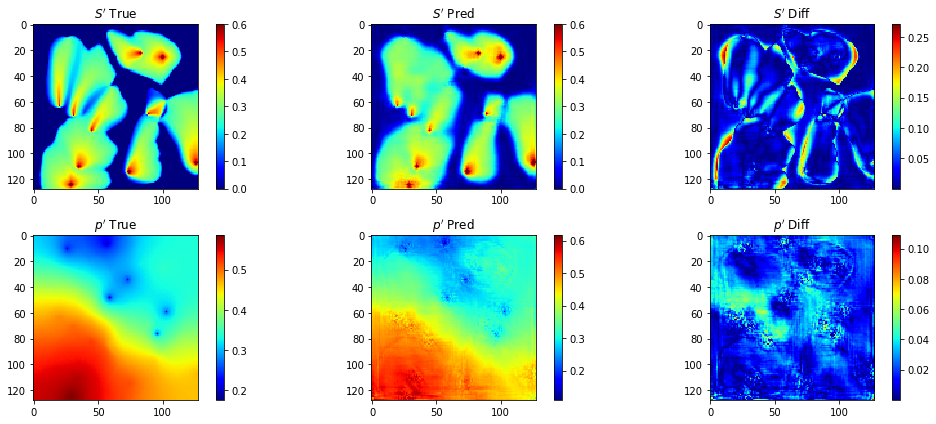

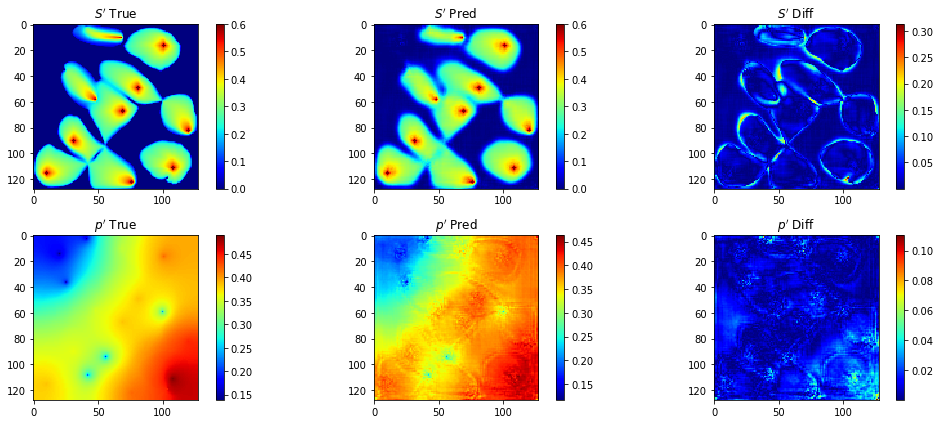

In [12]:
# train_x_y_hat0 = data_train_trial[..., 0]# xc
# train_y_hat0 = data_train_trial[..., [0], 1] #c
# train_x_hat0 = data_train_trial[..., 1:, 1] # x

n_plot_train = 2

for k in range(n_plot_train):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(2,3,1)
    plt.title('$S^{\prime}$ True')
    plt.imshow(train_x_hat0[k, ..., 0])
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,2)
    plt.title('$S^{\prime}$ Pred')
    plt.imshow(x_hat_pred_train[k, ..., 0])
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,3)
    plt.title('$S^{\prime}$ Diff')
    plt.imshow(np.abs(x_hat_pred_train[k, ..., 0] - train_x_hat0[k, ..., 0]))
#     plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,4)
    plt.imshow(train_x_hat0[k, ..., 1])
    plt.title('$p^{\prime}$ True')
#     plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,5)
    plt.imshow(x_hat_pred_train[k, ..., 1]) 
    plt.title('$p^{\prime}$ Pred')
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,6)
    plt.imshow(np.abs(x_hat_pred_train[k, ..., 1] - train_x_hat0[k, ..., 1]))
    plt.title('$p^{\prime}$ Diff')
    plt.colorbar(fraction=0.046)
    
    plt.tight_layout()
    plt.savefig("figs/" + case_string + model_string + "_train_results_%d_%dtrain_%depoch.pdf"%(k, train_nr, epoch), format='pdf')
    plt.show()

    

## Test simulation results

In [63]:
print(x_hat_pred_eval.shape)
print(eval_x_hat0.shape)

err_eval = np.abs(x_hat_pred_eval - eval_x_hat0)
rel_err_eval = np.sum(err_eval, axis=(1,2,3)) / np.sum(eval_x_hat0, axis=(1,2,3))
print(rel_err_eval.shape)
print(np.mean(rel_err_eval))

(8000, 128, 128, 2)
(8000, 128, 128, 2)
(8000,)
0.13267629789709323


In [64]:
rel_err_eval_2 = np.sum(err_eval, axis=(1,2)) / np.sum(eval_x_hat0, axis=(1,2))
print(rel_err_eval_2.shape)
print(np.mean(rel_err_eval_2,axis=0))

(8000, 2)
[0.29536933 0.0794574 ]


In [27]:
test_true = eval_x_hat0.reshape(20,100,4,128,128,2)
test_pred = x_hat_pred_eval.reshape(20,100,4,128,128,2)


case_name = 'horizontal_16w_fix_perm_test'

hw_w = h5py.File('/data/cees/zjin/cs231n/project/var-unet/data/' + case_name + '_results.hdf5', 'w')
hw_w.create_dataset('test_true', data = test_true)
hw_w.create_dataset('test_pred', data = test_pred)
hw_w.close()

In [38]:
print(epoch)

10


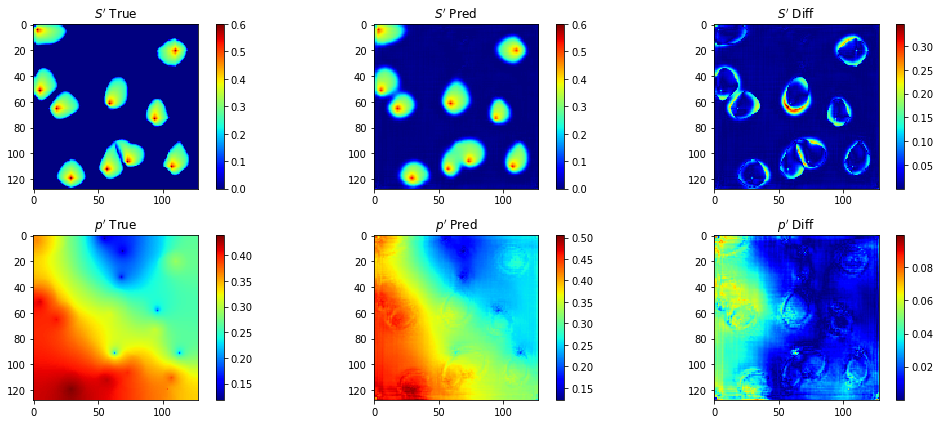

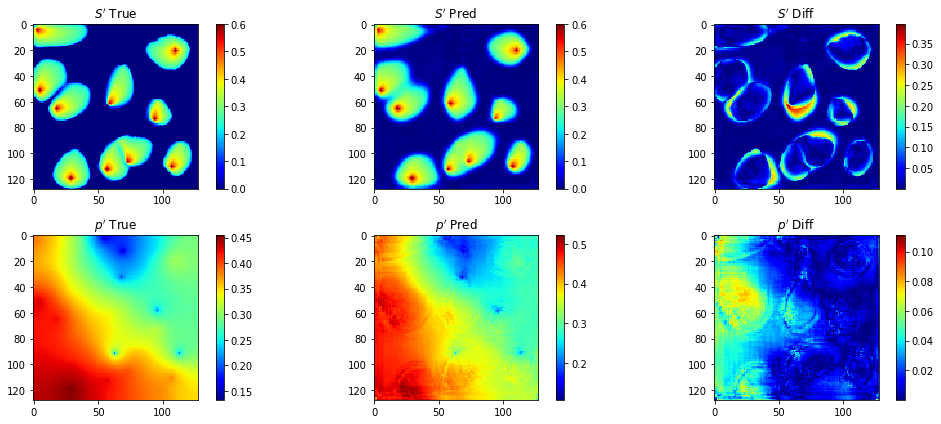

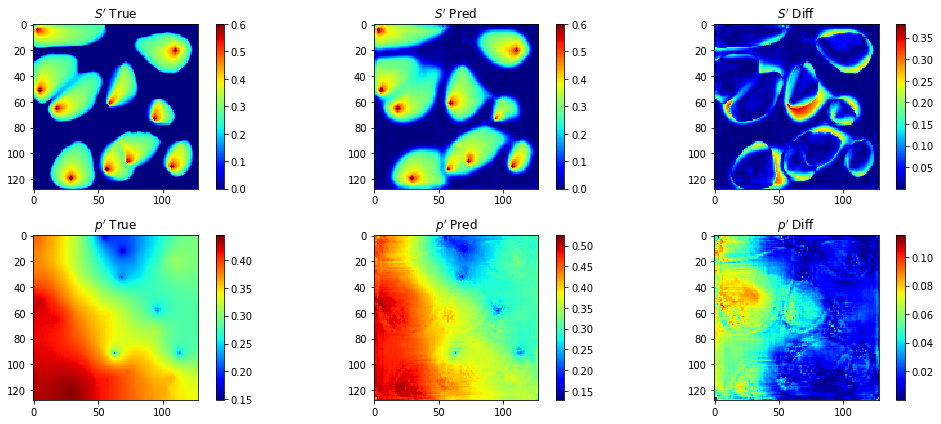

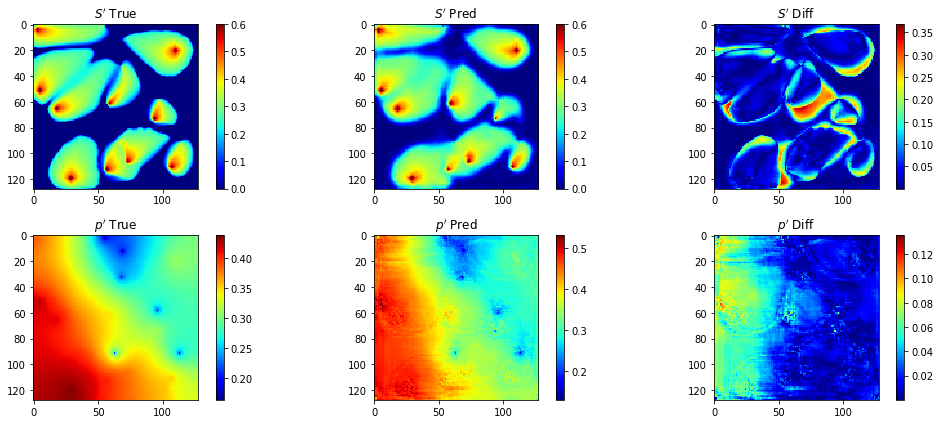

In [41]:
# eval_x_y_hat0 = data_eval_trial[..., 0]# xc
# eval_y_hat0 = data_eval_trial[..., [0], 1] #c
# eval_x_hat0 = data_eval_trial[..., 1:, 1] # x

n_plot_eval = 4

for k in range(n_plot_eval):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(2,3,1)
    plt.title('$S^{\prime}$ True')
    plt.imshow(eval_x_hat0[k, ..., 0])
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,2)
    plt.title('$S^{\prime}$ Pred')
    plt.imshow(x_hat_pred_eval[k, ..., 0])
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,3)
    plt.title('$S^{\prime}$ Diff')
    plt.imshow(np.abs(x_hat_pred_eval[k, ..., 0] - eval_x_hat0[k, ..., 0]))
#     plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,4)
    plt.imshow(eval_x_hat0[k, ..., 1])
    plt.title('$p^{\prime}$ True')
#     plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,5)
    plt.imshow(x_hat_pred_eval[k, ..., 1]) 
    plt.title('$p^{\prime}$ Pred')
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,3,6)
    plt.imshow(np.abs(x_hat_pred_eval[k, ..., 1] - eval_x_hat0[k, ..., 1]))
    plt.title('$p^{\prime}$ Diff')
    plt.colorbar(fraction=0.046)
    
    plt.tight_layout()
    plt.savefig("figs/" + case_string + model_string + "_eval_results_%d_%dtrain_%depoch.pdf"%(k, train_nr, epoch), format='pdf')
    plt.show()

    

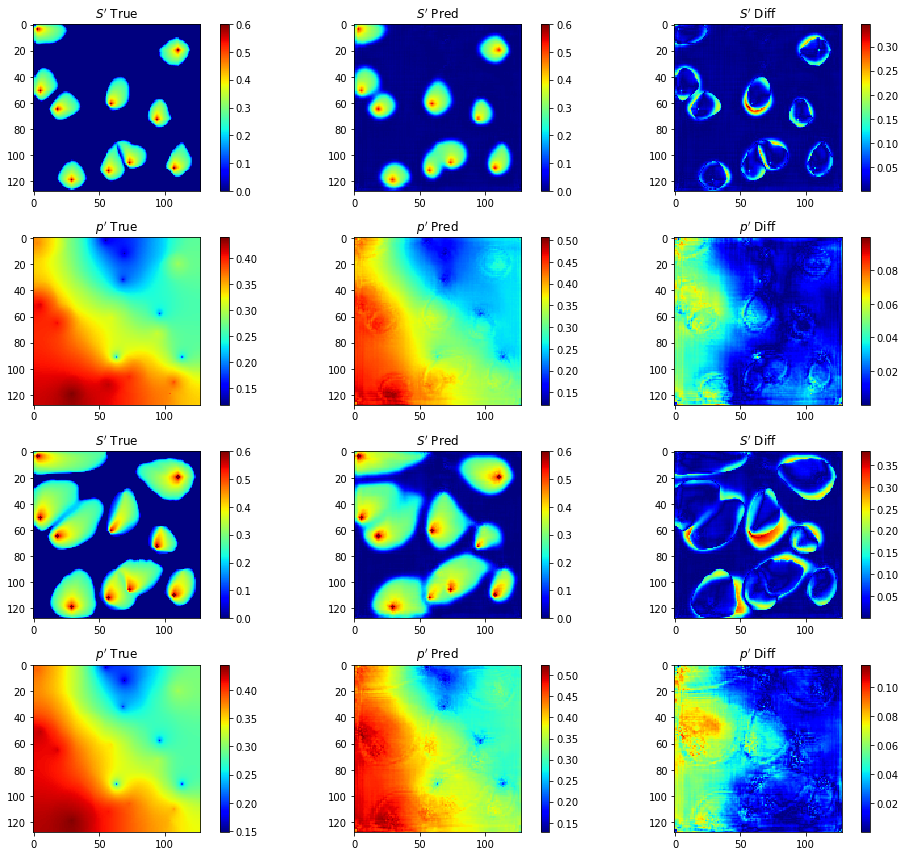

In [52]:
# eval_x_y_hat0 = data_eval_trial[..., 0]# xc
# eval_y_hat0 = data_eval_trial[..., [0], 1] #c
# eval_x_hat0 = data_eval_trial[..., 1:, 1] # x

plt.figure(figsize=(15, 12))
item = [0,2]

for i,k in enumerate(item):
    plt.subplot(4,3,1+i*6)
    plt.title('$S^{\prime}$ True')
    plt.imshow(eval_x_hat0[k, ..., 0])
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)

    plt.subplot(4,3,2+i*6)
    plt.title('$S^{\prime}$ Pred')
    plt.imshow(x_hat_pred_eval[k, ..., 0])
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)

    plt.subplot(4,3,3+i*6)
    plt.title('$S^{\prime}$ Diff')
    plt.imshow(np.abs(x_hat_pred_eval[k, ..., 0] - eval_x_hat0[k, ..., 0]))
    #     plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)

    plt.subplot(4,3,4+i*6)
    plt.imshow(eval_x_hat0[k, ..., 1])
    plt.title('$p^{\prime}$ True')
    #     plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)

    plt.subplot(4,3,5+i*6)
    plt.imshow(x_hat_pred_eval[k, ..., 1]) 
    plt.title('$p^{\prime}$ Pred')
    plt.colorbar(fraction=0.046)

    plt.subplot(4,3,6+i*6)
    plt.imshow(np.abs(x_hat_pred_eval[k, ..., 1] - eval_x_hat0[k, ..., 1]))
    plt.title('$p^{\prime}$ Diff')
    plt.colorbar(fraction=0.046)
    
    plt.tight_layout()
plt.savefig("figs/" + case_string + model_string + "_eval_results_%d_%dtrain_%depoch.pdf"%(k, train_nr, epoch), format='pdf')
plt.show()

    

In [28]:
print(test_true.shape)
print(test_pred.shape)

(20, 100, 4, 128, 128, 2)
(20, 100, 4, 128, 128, 2)


In [29]:
test_true_mean = np.mean(test_true,axis=1)
test_pred_mean = np.mean(test_pred,axis=1)
print(test_true_mean.shape)
print(test_pred_mean.shape)

(20, 4, 128, 128, 2)
(20, 4, 128, 128, 2)


In [30]:
test_true_var = np.var(test_true,axis=1)
test_pred_var = np.var(test_pred,axis=1)
print(test_true_var.shape)
print(test_pred_var.shape)

(20, 4, 128, 128, 2)
(20, 4, 128, 128, 2)


In [58]:
err_eval_mean = np.abs(test_true_mean - test_pred_mean)
rel_err_eval_mean = np.sum(err_eval_mean, axis=(0,1,2,3)) / np.sum(test_true_mean, axis=(0,1,2,3))
print(rel_err_eval_mean.shape)
print(rel_err_eval_mean)
print(np.mean(rel_err_eval_mean))


(2,)
[0.2184375  0.04596621]
0.13220185614188545


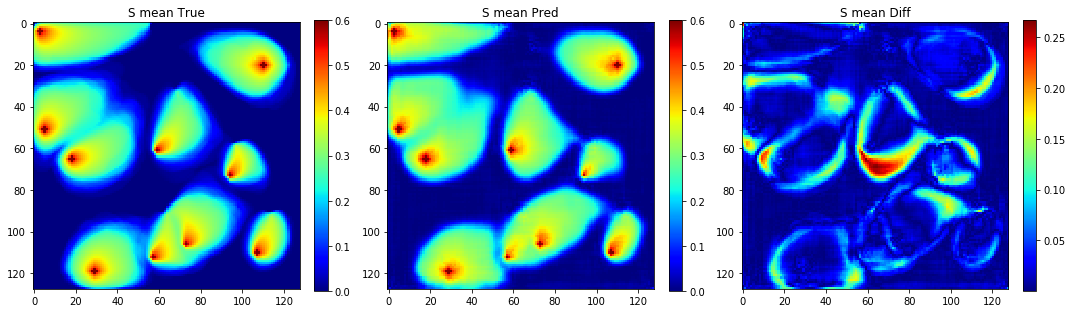

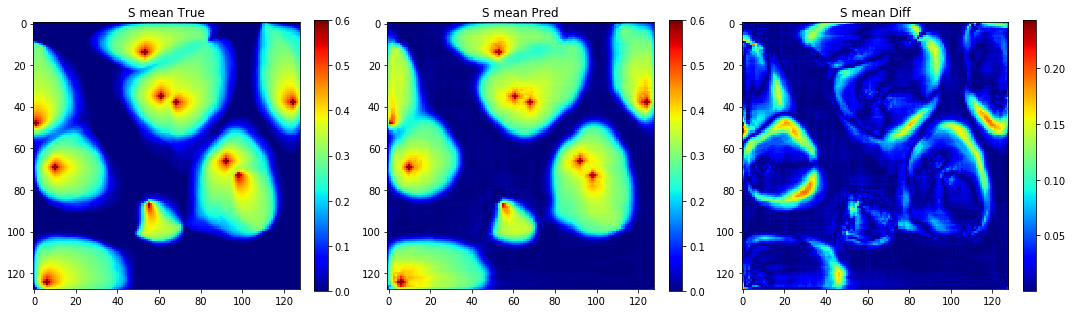

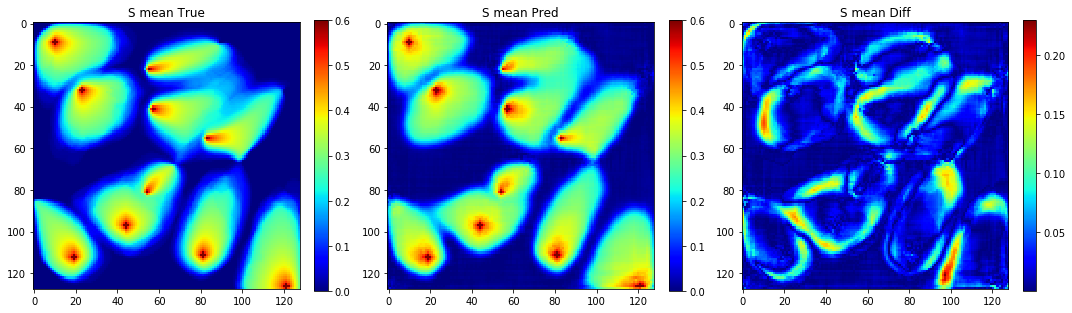

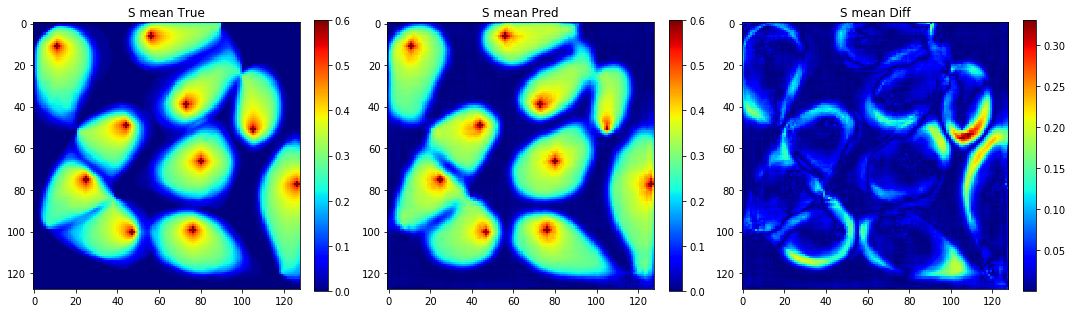

In [43]:
# Saturation

n_plot_eval = 4
time_step = 2

for k in range(n_plot_eval):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1,3,1)
    plt.title('S mean True')
    plt.imshow(test_true_mean[k,time_step, ..., 0])
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,3,2)
    plt.title('S mean Pred')
    plt.imshow(test_pred_mean[k,time_step, ..., 0])
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,3,3)
    plt.title('S mean Diff')
    plt.imshow(np.abs(test_true_mean[k,time_step, ..., 0] - test_pred_mean[k,time_step, ..., 0]))
#     plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
#     plt.subplot(2,3,4)
#     plt.imshow(test_true_var[k,time_step, ..., 0])
#     plt.title('S var True')
# #     plt.clim([0, 0.6])
#     plt.colorbar(fraction=0.046)
    
#     plt.subplot(2,3,5)
#     plt.imshow(test_pred_var[k,time_step, ..., 0]) 
#     plt.title('S var Pred')
#     plt.colorbar(fraction=0.046)
    
#     plt.subplot(2,3,6)
#     plt.imshow(np.abs(test_true_var[k,time_step, ..., 0] - test_pred_var[k,time_step, ..., 0]))
#     plt.title('S var Diff')
#     plt.colorbar(fraction=0.046)
    
    plt.tight_layout()
    plt.savefig("figs/" + case_string + model_string + "_eval_results_mean_sat_%d_%dtrain_%depoch.pdf"%(k, train_nr, epoch), format='pdf')
    plt.show()

    

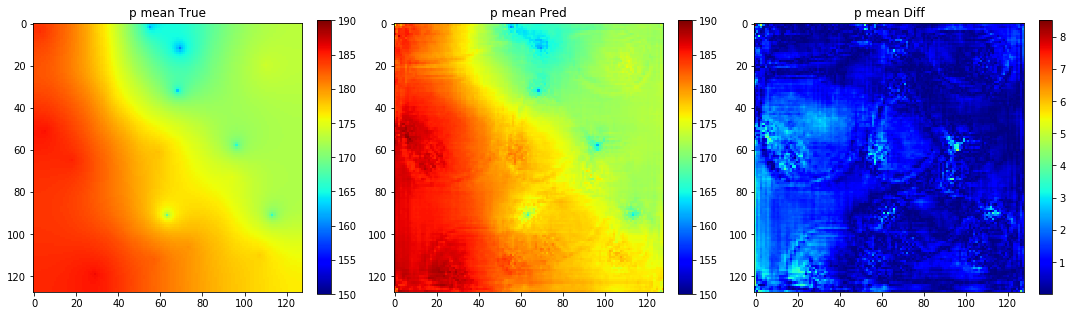

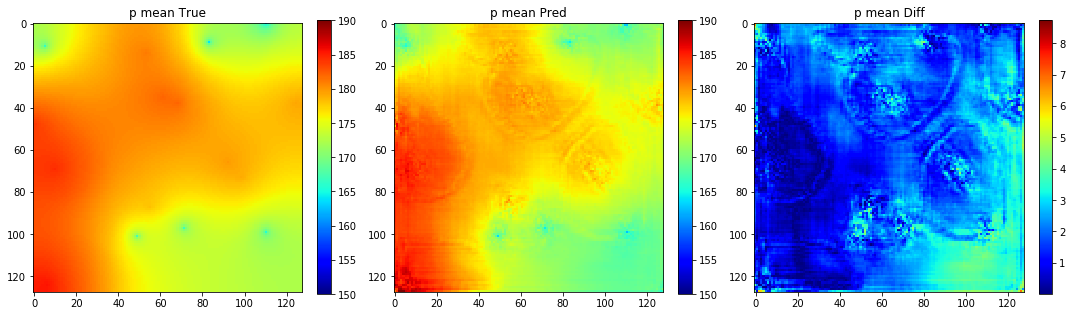

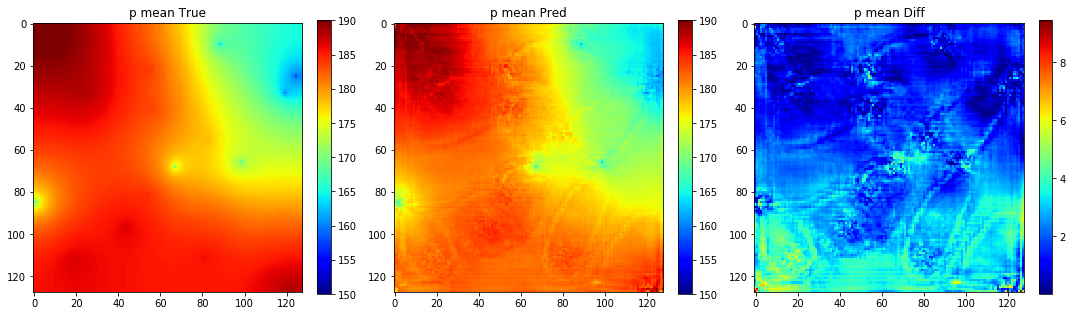

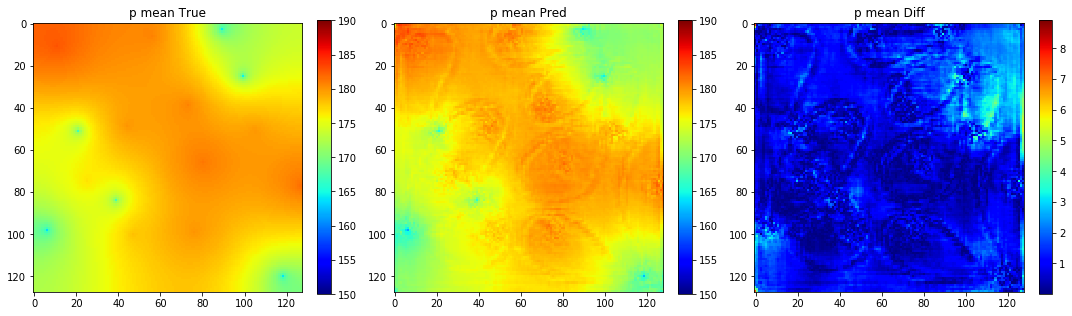

In [49]:
# Pressure
max_p = 225 # earlier 200
min_p = 150
diff_p = max_p - min_p

test_true_mean_1 = test_true_mean * diff_p + min_p
test_pred_mean_1 = test_pred_mean * diff_p + min_p

n_plot_eval = 4
time_step = 2

for k in range(n_plot_eval):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1,3,1)
    plt.title('p mean True')
    plt.imshow(test_true_mean_1[k,time_step, ..., 1])
    plt.clim([min_p, max_p-35])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,3,2)
    plt.title('p mean Pred')
    plt.imshow(test_pred_mean_1[k,time_step, ..., 1])
    plt.clim([min_p, max_p-35])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,3,3)
    plt.title('p mean Diff')
    plt.imshow(np.abs(test_true_mean_1[k,time_step, ..., 1] - test_pred_mean_1[k,time_step, ..., 1]))
#     plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
#     plt.subplot(2,3,4)
#     plt.imshow(test_true_var[k,time_step, ..., 1])
#     plt.title('p var True')
# #     plt.clim([0, 0.6])
#     plt.colorbar(fraction=0.046)
    
#     plt.subplot(2,3,5)
#     plt.imshow(test_pred_var[k,time_step, ..., 1]) 
#     plt.title('p var Pred')
#     plt.colorbar(fraction=0.046)
    
#     plt.subplot(2,3,6)
#     plt.imshow(np.abs(test_true_var[k,time_step, ..., 1] - test_pred_var[k,time_step, ..., 1]))
#     plt.title('p var Diff')
#     plt.colorbar(fraction=0.046)
    
    plt.tight_layout()
    plt.savefig("figs/" + case_string + model_string + "_eval_results_mean_pres_%d_%dtrain_%depoch.pdf"%(k, train_nr, epoch), format='pdf')
    plt.show()

    